# Step 1 - Importing all libraries used throughout the project

In [1]:
import functions_vanguard as vd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

# Step 2 - Importing data frames, analyzing and cleaning

## 2.1.1 - Importing Clients Dataframe (df_final_demo)

In [2]:
df_final_demo = vd.import_dataframe()
df_final_demo
   

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0
...,...,...,...,...,...,...,...,...,...
70604,7993686,4.0,56.0,38.5,U,3.0,1411062.68,5.0,5.0
70605,8981690,12.0,148.0,31.0,M,2.0,101867.07,6.0,6.0
70606,333913,16.0,198.0,61.5,F,2.0,40745.00,3.0,3.0
70607,1573142,21.0,255.0,68.0,M,3.0,475114.69,4.0,4.0


## 2.1.2 Exploring the Dataframe's columns

*Display basic information about the dataset*, 

*Displaying information about **clnt_tenure_yr** (client tenure in years), as well as plotting a histogram to visualize the column's values*

*Displaying information about **clnt_age** (client age), as well as plotting a histogram to visualize the column's values*

*Displaying information about **gendr** (gender), as well as creating a pie chart to visualize the column's values*

*Displaying iformation about **num_accounts** (number of accounts), as well as creating a pie chart and histogram to visualize the column's values*

*Displaying iformation about **bal** (balance)*

*Displaying iformation about **logons_6_mnth** (log on in the past 6 months), as well as creating a histogram to visualize the column's values*

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70609 entries, 0 to 70608
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         70609 non-null  int64  
 1   clnt_tenure_yr    70595 non-null  float64
 2   clnt_tenure_mnth  70595 non-null  float64
 3   clnt_age          70594 non-null  float64
 4   gendr             70595 non-null  object 
 5   num_accts         70595 non-null  float64
 6   bal               70595 non-null  float64
 7   calls_6_mnth      70595 non-null  float64
 8   logons_6_mnth     70595 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 4.8+ MB
None
clnt_tenure_yr
6.0     7092
5.0     6955
7.0     4955
4.0     4687
15.0    4564
8.0     4045
14.0    3646
12.0    3631
13.0    3607
9.0     3357
11.0    2920
10.0    2775
16.0    2714
21.0    2257
20.0    1580
22.0    1492
17.0    1373
23.0    1279
18.0    1206
19.0    1153
24.0     846
26.0     660
27.0   

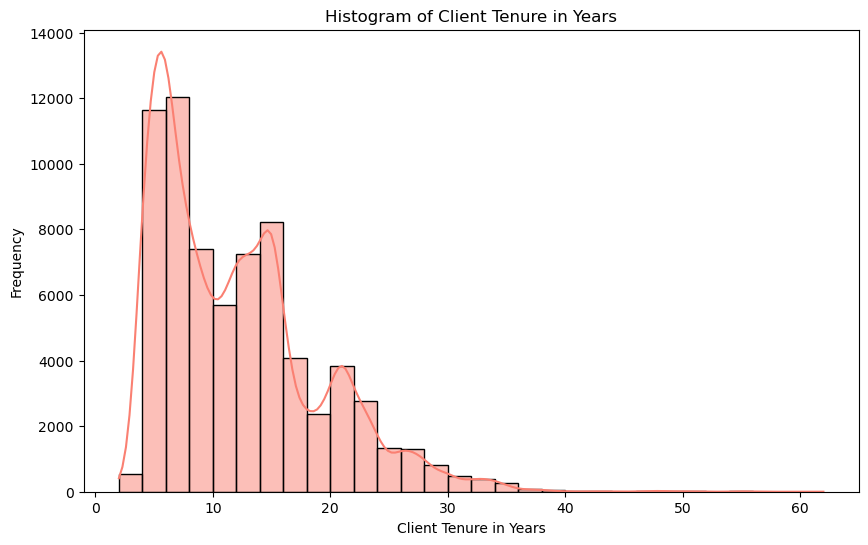

clnt_age
58.5    859
55.5    830
29.5    829
28.5    827
57.5    826
       ... 
96.0      2
14.0      2
94.5      1
95.5      1
13.5      1
Name: count, Length: 165, dtype: int64


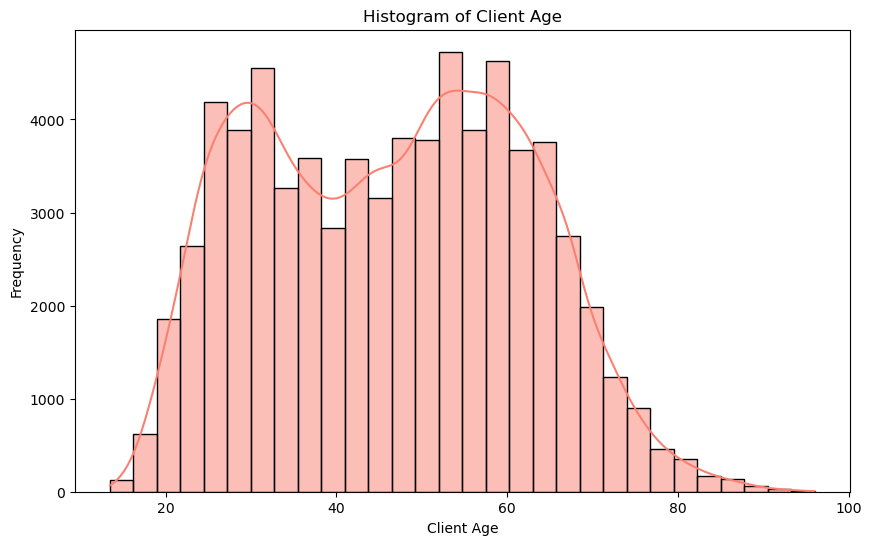

gendr
U    24122
M    23724
F    22746
X        3
Name: count, dtype: int64


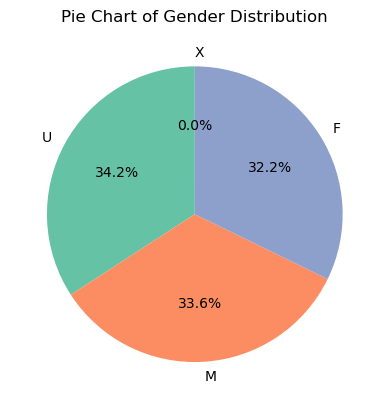

num_accts
2.0    55497
3.0    12529
4.0     2241
5.0      284
6.0       33
7.0        8
1.0        2
8.0        1
Name: count, dtype: int64


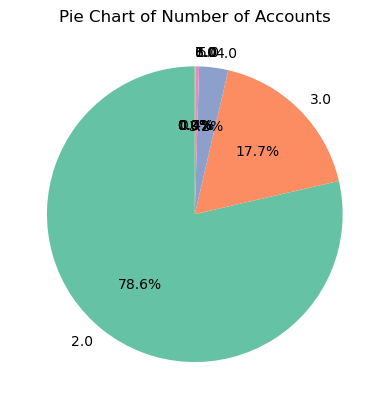

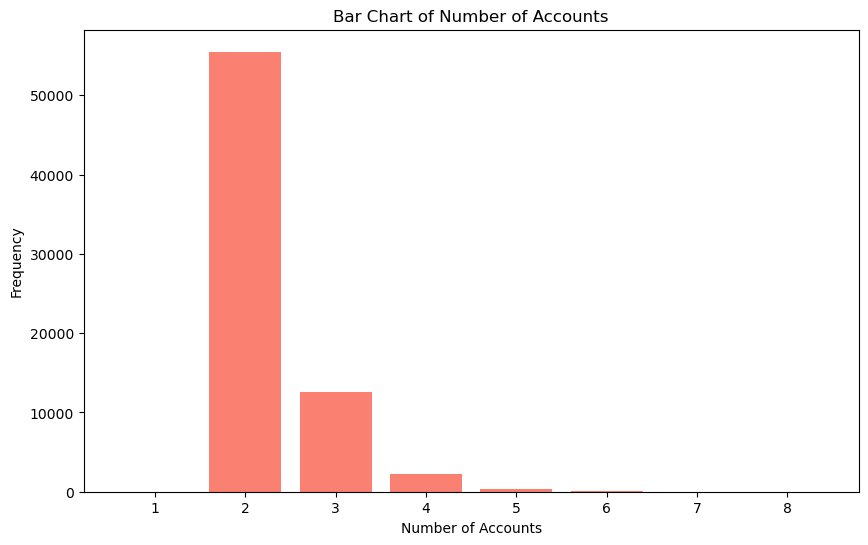

bal
31188.62     5
29388.51     4
31398.74     3
29389.11     3
29388.50     3
            ..
26088.34     1
51203.28     1
94714.11     1
52086.48     1
157498.73    1
Name: count, Length: 70333, dtype: int64
count    7.059500e+04
mean     1.474452e+05
std      3.015087e+05
min      1.378942e+04
25%      3.734683e+04
50%      6.333290e+04
75%      1.375449e+05
max      1.632004e+07
Name: bal, dtype: float64
logons_6_mnth
9.0    12350
3.0    10243
4.0    10220
7.0     9893
5.0     9254
6.0     7878
8.0     4810
2.0     3009
1.0     2938
Name: count, dtype: int64


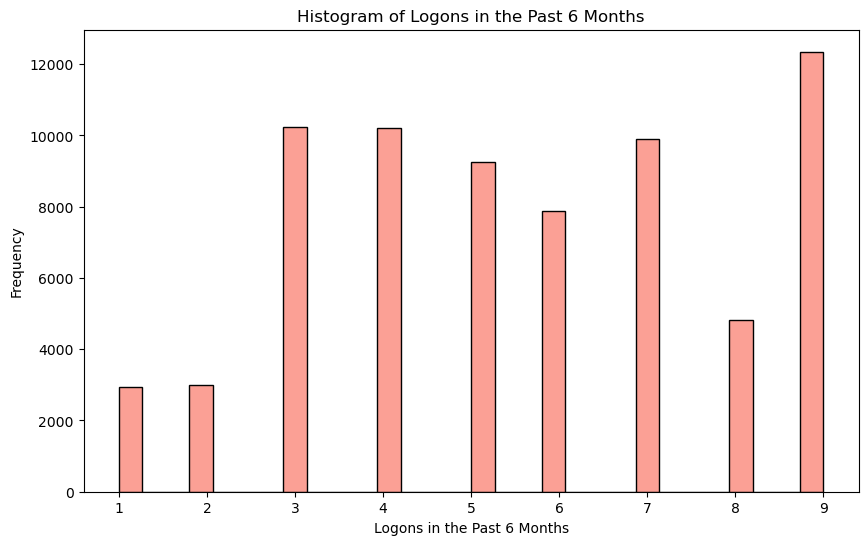

In [3]:
vd.analyze_dataframe(df_final_demo)

## 2.1.3 - Analyzing Client Demographics

First, we will create a new column to visualize the total tenure in months.

Second, we will categorize the the clients based on their total tenure (in months). They can either be **New** or **Long Standing**

Third, it is important to know whether the clients are **young** or **old**. 

In [4]:
df_final_demo = vd.analyze_client_demographics(df_final_demo)
df_final_demo

   client_id  clnt_tenure_yr  clnt_tenure_mnth  total_tenure_months
0     836976             6.0              73.0                145.0
1    2304905             7.0              94.0                178.0
2    1439522             5.0              64.0                124.0
3    1562045            16.0             198.0                390.0
4    5126305            12.0             145.0                289.0
   client_id  client_status  total_tenure_months
0     836976  Long-standing                145.0
1    2304905  Long-standing                178.0
2    1439522  Long-standing                124.0
3    1562045  Long-standing                390.0
4    5126305  Long-standing                289.0
   client_id  clnt_age age_group
0     836976      60.5     Older
1    2304905      58.0     Older
2    1439522      32.0   Younger
3    1562045      49.0     Older
4    5126305      33.0   Younger
age_group
Younger    35527
Older      35082
Name: count, dtype: int64


,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,total_tenure_months,client_status,age_group
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0,145.0,Long-standing,Older
1,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0,178.0,Long-standing,Older
2,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0,124.0,Long-standing,Younger
3,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0,390.0,Long-standing,Older
4,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0,289.0,Long-standing,Younger
...,...,...,...,...,...,...,...,...,...,...,...,...
70604,7993686,4.0,56.0,38.5,U,3.0,1411062.68,5.0,5.0,104.0,Long-standing,Younger
70605,8981690,12.0,148.0,31.0,M,2.0,101867.07,6.0,6.0,292.0,Long-standing,Younger
70606,333913,16.0,198.0,61.5,F,2.0,40745.00,3.0,3.0,390.0,Long-standing,Older
70607,1573142,21.0,255.0,68.0,M,3.0,475114.69,4.0,4.0,507.0,Long-standing,Older


## 2.1.3 - Identifying Primary Clients

Primary Clients by Tenure and Age Group:
   client_status age_group  count
0  Long-standing     Older  35082
1  Long-standing   Younger  35527


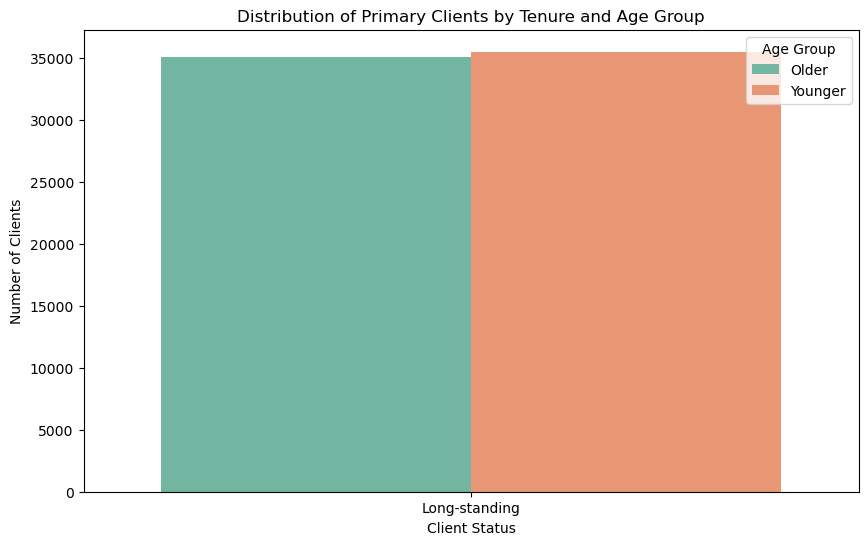

,client_status,age_group,count
0,Long-standing,Older,35082
1,Long-standing,Younger,35527


In [5]:
vd.identify_primary_clients(df_final_demo)

## 2.1.4 Cleaning df_final_demo 

First, we will take a look at which columns are completly empty (except for client_id, whic does not have any null values).

Secondly, we will remove all these rows.

Finally, we will take a look a the types of each column and make adjustments if needed.

In [6]:
df_final_demo=vd.clean_dataframe(df_final_demo)
df_final_demo

Rows with null values in the 'bal' column:
       client_id  clnt_tenure_yr  clnt_tenure_mnth  clnt_age gendr  num_accts  \
4164     7402828             NaN               NaN       NaN   NaN        NaN   
8316      355337             NaN               NaN       NaN   NaN        NaN   
8677     8412164             NaN               NaN       NaN   NaN        NaN   
13444    2222915             NaN               NaN       NaN   NaN        NaN   
18066    4876926             NaN               NaN       NaN   NaN        NaN   
25961    5277910             NaN               NaN       NaN   NaN        NaN   
28432    7616759             NaN               NaN       NaN   NaN        NaN   
35323    8191345             NaN               NaN       NaN   NaN        NaN   
43518    1227228             NaN               NaN       NaN   NaN        NaN   
46076    8611797             NaN               NaN       NaN   NaN        NaN   
47189    5144725             NaN               NaN       NaN   NaN

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,total_tenure_months,client_status,age_group
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0,145.0,Long-standing,Older
1,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0,178.0,Long-standing,Older
2,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0,124.0,Long-standing,Younger
3,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0,390.0,Long-standing,Older
4,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0,289.0,Long-standing,Younger
...,...,...,...,...,...,...,...,...,...,...,...,...
70604,7993686,4.0,56.0,38.5,U,3.0,1411062.68,5.0,5.0,104.0,Long-standing,Younger
70605,8981690,12.0,148.0,31.0,M,2.0,101867.07,6.0,6.0,292.0,Long-standing,Younger
70606,333913,16.0,198.0,61.5,F,2.0,40745.00,3.0,3.0,390.0,Long-standing,Older
70607,1573142,21.0,255.0,68.0,M,3.0,475114.69,4.0,4.0,507.0,Long-standing,Older


## 2.2.1 Importing DataFrame Part 1 which provides information about the visits to Vanguard

In [7]:
df_pt1 = vd.import_and_check_dataframe_part1()
df_pt1

Null values in each column:
client_id       0
visitor_id      0
visit_id        0
process_step    0
date_time       0
dtype: int64


,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04
...,...,...,...,...,...
343136,2443347,465784886_73090545671,136329900_10529659391_316129,confirm,2017-03-31 15:15:46
343137,2443347,465784886_73090545671,136329900_10529659391_316129,step_3,2017-03-31 15:14:53
343138,2443347,465784886_73090545671,136329900_10529659391_316129,step_2,2017-03-31 15:12:08
343139,2443347,465784886_73090545671,136329900_10529659391_316129,step_1,2017-03-31 15:11:37


There aren't any null values, so we do not have to clean anything.

## 2.3.1 - Importing DataFrame Part 2 

In [8]:
df_pt2 = vd.import_and_check_dataframe_part2()
display(df_pt2)

Null values in each column:
client_id       0
visitor_id      0
visit_id        0
process_step    0
date_time       0
dtype: int64


,client_id,visitor_id,visit_id,process_step,date_time
0,763412,601952081_10457207388,397475557_40440946728_419634,confirm,2017-06-06 08:56:00
1,6019349,442094451_91531546617,154620534_35331068705_522317,confirm,2017-06-01 11:59:27
2,6019349,442094451_91531546617,154620534_35331068705_522317,step_3,2017-06-01 11:58:48
3,6019349,442094451_91531546617,154620534_35331068705_522317,step_2,2017-06-01 11:58:08
4,6019349,442094451_91531546617,154620534_35331068705_522317,step_1,2017-06-01 11:57:58
...,...,...,...,...,...
412259,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:46:10
412260,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:45:29
412261,9668240,388766751_9038881013,922267647_3096648104_968866,step_1,2017-05-24 18:44:51
412262,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:44:34


## 2.3.2 - Merging the Twin Dataframes

DataFrame Part 2 is an extension to DataFrame Part 1; therefore, they should be merged.

In [9]:
df = vd.merge_dataframes(df_pt1, df_pt2)
df

,client_id,visitor_id,visit_id,process_step,date_time
285512,169,201385055_71273495308,749567106_99161211863_557568,step_3,2017-04-12 20:22:05
285511,169,201385055_71273495308,749567106_99161211863_557568,confirm,2017-04-12 20:23:09
285513,169,201385055_71273495308,749567106_99161211863_557568,step_2,2017-04-12 20:20:31
285514,169,201385055_71273495308,749567106_99161211863_557568,step_1,2017-04-12 20:19:45
285515,169,201385055_71273495308,749567106_99161211863_557568,start,2017-04-12 20:19:36
...,...,...,...,...,...
305392,9999875,738878760_1556639849,931268933_219402947_599432,step_1,2017-06-01 22:40:08
305388,9999875,738878760_1556639849,931268933_219402947_599432,confirm,2017-06-01 22:48:39
305389,9999875,738878760_1556639849,931268933_219402947_599432,step_3,2017-06-01 22:44:58
305391,9999875,738878760_1556639849,931268933_219402947_599432,step_1,2017-06-01 22:41:28


## 2.4.1 - Importing Data Frame about the different groups of clients (Test/Control)

We want to determine the **size** of each of the groups. 

Determining the amount of **null values** in the Dataframe

In [10]:
df_final_experiment = vd.import_and_analyze_experiment_clients()
df_final_experiment

Size of each group:
Variation
Control    23532
Test       26968
dtype: int64
Null values in each column:
client_id        0
Variation    20109
dtype: int64


,client_id,Variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control
...,...,...
70604,2443347,NaN
70605,8788427,NaN
70606,266828,NaN
70607,1266421,NaN


In [11]:
variation_df = vd.merge_and_clean_dataframes(df_final_demo, df, df_final_experiment)
variation_df

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,total_tenure_months,client_status,age_group,visitor_id,visit_id,process_step,date_time,Variation
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0,145.0,Long-standing,Older,427070339_1413275162,228976764_46825473280_96584,confirm,2017-04-02 11:46:45,Test
1,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0,145.0,Long-standing,Older,427070339_1413275162,228976764_46825473280_96584,start,2017-04-02 11:21:28,Test
2,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0,145.0,Long-standing,Older,427070339_1413275162,104438405_2368283624_817211,start,2017-03-29 11:02:44,Test
3,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0,145.0,Long-standing,Older,427070339_1413275162,228976764_46825473280_96584,step_2,2017-04-02 11:22:24,Test
4,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0,145.0,Long-standing,Older,427070339_1413275162,104438405_2368283624_817211,start,2017-03-29 11:01:40,Test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321190,7468138,18.0,222.0,61.0,F,3.0,209278.15,0.0,3.0,438.0,Long-standing,Older,317123960_46820919455,769876461_30381166055_830233,start,2017-03-31 00:16:12,Test
321191,7468138,18.0,222.0,61.0,F,3.0,209278.15,0.0,3.0,438.0,Long-standing,Older,317123960_46820919455,769876461_30381166055_830233,start,2017-03-30 23:55:11,Test
321192,7468138,18.0,222.0,61.0,F,3.0,209278.15,0.0,3.0,438.0,Long-standing,Older,317123960_46820919455,769876461_30381166055_830233,start,2017-03-30 23:58:40,Test
321193,7468138,18.0,222.0,61.0,F,3.0,209278.15,0.0,3.0,438.0,Long-standing,Older,317123960_46820919455,769876461_30381166055_830233,step_1,2017-03-30 23:58:51,Test


In [ ]:
control_df = vd.get_control_df(variation_df)
test_df = vd.get_test_df(variation_df)

# Step 3 - Determining KPI's

## 3.1 - Analyzing the Time Spent on Each Step

In [ ]:
analyze_time_spent(variation_df)

In [ ]:
analyze_session_durations(variation_df)

In [ ]:
#lEAVE IT FOR NOW
process_step_counts = df['process_step'].value_counts()
process_step_counts

In [ ]:
#lEAVE IT FOR NOW
# Count the occurrences of each process step
process_step_counts = df['process_step'].value_counts()

# Plot a bar chart
plt.figure(figsize=(10, 6))
process_step_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Process Steps')
plt.xlabel('Process Step')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Display the plot
plt.show()

## 3.2 - Analyzing Completion Rate

# KPI's

In [ ]:
# Total number of sessions for each group
total_sessions = variation_df.groupby('Variation')['visit_id'].nunique().reset_index(name='total_sessions')

# Filter the data to only include rows where process_step is "confirm"
confirm_steps = variation_df[variation_df['process_step'] == 'confirm']

# Count the number of sessions that reached the "confirm" step for each group
confirm_sessions = confirm_steps.groupby('Variation')['visit_id'].nunique().reset_index(name='confirm_sessions')

#Merge total sessions with confirm sessions
completion_data = pd.merge(total_sessions, confirm_sessions, on='Variation')

# Calculate the completion rate
completion_data['completion_rate'] = (completion_data['confirm_sessions'] / completion_data['total_sessions']) * 100

print(completion_data)

In [ ]:
#create a bar chart
plt.figure(figsize=(5, 3))
sns.barplot(x='Variation', y='completion_rate', data=completion_data, palette='Set2')
plt.title('Completion Rate by Variation')
plt.xlabel('Variation')
plt.ylabel('Completion Rate (%)')
plt.ylim(0, 100)
plt.show()

In [ ]:
# Calculate the observed increase in completion rate
completion_rate_control = completion_data.loc[completion_data['Variation'] == 'Control', 'completion_rate'].values[0]
completion_rate_test = completion_data.loc[completion_data['Variation'] == 'Test', 'completion_rate'].values[0]
observed_increase = completion_rate_test - completion_rate_control
print(f"Observed Increase in Completion Rate: {observed_increase:.2f}%")

import numpy as np
from scipy.stats import chi2_contingency

confirm_sessions_control = 16046
total_sessions_control = 32189
confirm_sessions_test = 21731
total_sessions_test = 37136

# Create the contingency table
contingency_table = np.array([
    [confirm_sessions_control, total_sessions_control - confirm_sessions_control],
    [confirm_sessions_test, total_sessions_test - confirm_sessions_test]
])

# Perform the chi-squared test
chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

# Print the test statistic and p-value
print(f"Chi-Squared Statistic: {chi2_stat:.2f}")
print(f"P-Value: {p_value:.4f}")

threshold = 5.0  # 5% threshold
if observed_increase >= threshold and p_value < 0.05:
    print("The observed increase in completion rate meets or exceeds the 5% threshold and is statistically significant.")
else:
    print("The observed increase in completion rate does not meet the 5% threshold or is not statistically significant.")


In [ ]:
#Amoutn of people per group.
variation_counts = variation_df["Variation"].value_counts()
variation_counts.plot(kind="bar", color = "lightskyblue" )
plt.xlabel("Group")
plt.ylabel("Frequency")

In [ ]:
print(control_df.client_id.count(),test_df.client_id.count())

In [ ]:
# # Function to calculate time spent on each step
# def calculate_step_duration(df):
#     # Ensure 'date_time' is sorted within each user session
#     df = df.sort_values(by=['client_id', 'visitor_id', 'date_time'])
    
#     # Calculate the time spent on each step by finding the difference between consecutive steps
#     df['next_step_time'] = df.groupby(['client_id', 'visitor_id'])['date_time'].shift(-1)
#     df['time_spent'] = (df['next_step_time'] - df['date_time']).dt.total_seconds()
    
#     # Drop rows where 'time_spent' is NaN (e.g., the last step in each session)
#     df = df.dropna(subset=['time_spent'])
    
#     # Calculate the average duration spent on each step
#     avg_duration_per_step = df.groupby('process_step')['time_spent'].mean().reset_index()
#     avg_duration_per_step.columns = ['process_step', 'avg_duration_seconds']
    
#     return avg_duration_per_step

# # Apply the function
# average_duration_per_step = calculate_step_duration(variation_df)

# # Print the results
# print("Average Duration Spent on Each Step (in seconds):")
# print(average_duration_per_step)

In [ ]:
# plt.figure(figsize=(10, 6))
# sns.barplot(x='process_step', y='avg_duration_seconds', data=average_duration_per_step, palette='viridis')
# plt.title('Average Duration Spent on Each Step (in seconds)')
# plt.xlabel('Process Step')
# plt.ylabel('Average Duration (seconds)')
# plt.xticks(rotation=45)
# plt.show()

In [ ]:


# # General function to calculate time spent on each step
# def calculate_step_duration(df):
#     # Ensure 'date_time' is sorted within each user session
#     df = df.sort_values(by=['client_id', 'visitor_id', 'date_time'])
    
#     # Calculate the time spent on each step by finding the difference between consecutive steps
#     df['next_step_time'] = df.groupby(['client_id', 'visitor_id'])['date_time'].shift(-1)
#     df['time_spent'] = (df['next_step_time'] - df['date_time']).dt.total_seconds()
    
#     # Drop rows where 'time_spent' is NaN (e.g., the last step in each session)
#     df = df.dropna(subset=['time_spent'])
    
#     # Calculate the average duration spent on each step
#     avg_duration_per_step = df.groupby('process_step')['time_spent'].mean().reset_index()
#     avg_duration_per_step.columns = ['process_step', 'avg_duration_seconds']
    
#     return avg_duration_per_step

# # Apply the function to control and test dataframes
# average_duration_per_step_control = calculate_step_duration(control_df)
# average_duration_per_step_test = calculate_step_duration(test_df)

# # Print the results
# print("Average Duration Spent on Each Step (Control Group) (in seconds):")
# print(average_duration_per_step_control)

# print("Average Duration Spent on Each Step (Test Group) (in seconds):")
# print(average_duration_per_step_test)



In [ ]:

# Assuming 'variation_df' is your DataFrame and it includes 'date_time' and 'process_step' columns
control_df = variation_df[variation_df["Variation"] == "Control"]
test_df = variation_df[variation_df["Variation"] == "Test"]

# General function to calculate time spent on each step
def calculate_step_duration(df):
    # Ensure 'date_time' is sorted within each user session
    df = df.sort_values(by=['client_id', 'visitor_id', 'date_time'])
    
    # Calculate the time spent on each step by finding the difference between consecutive steps
    df['next_step_time'] = df.groupby(['client_id', 'visitor_id'])['date_time'].shift(-1)
    df['time_spent'] = (df['next_step_time'] - df['date_time']).dt.total_seconds()
    
    # Drop rows where 'time_spent' is NaN (e.g., the last step in each session)
    df = df.dropna(subset=['time_spent'])
    
    # Calculate the average duration spent on each step
    avg_duration_per_step = df.groupby('process_step')['time_spent'].mean().reset_index()
    avg_duration_per_step.columns = ['process_step', 'avg_duration_seconds']
    
    return avg_duration_per_step

# Apply the function to control and test dataframes
average_duration_per_step_control = calculate_step_duration(control_df)
average_duration_per_step_test = calculate_step_duration(test_df)

# Add a column to distinguish between control and test group
average_duration_per_step_control['Group'] = 'Control'
average_duration_per_step_test['Group'] = 'Test'


In [ ]:
# Combine both dataframes
combined_df = pd.concat([average_duration_per_step_control, average_duration_per_step_test])

# Plotting
plt.figure(figsize=(12, 6))

# Create separate palettes for control and test groups
palette = {'Control': 'skyblue', 'Test': 'coral'}

# Create a bar plot using Seaborn
sns.barplot(x='process_step', y='avg_duration_seconds', hue='Group', data=combined_df, palette=palette)

# Set plot title and labels
plt.title('Average Duration Spent on Each Step by Group (in seconds)')
plt.xlabel('Process Step')
plt.ylabel('Average Duration (seconds)')

# Show plot
plt.show()

In [ ]:
# Assuming you have DataFrames `test_df` and `control_df` with a column 'process_step'

# Count the occurrences of each unique value in the 'process_step' column for both DataFrames
process_step_counts_test = test_df['process_step'].value_counts().rename('Test')
process_step_counts_control = control_df['process_step'].value_counts().rename('Control')

# Normalize the counts by the total number of entries in each group
total_test = len(test_df)
total_control = len(control_df)

normalized_test_counts = process_step_counts_test / total_test
normalized_control_counts = process_step_counts_control / total_control

# Combine the normalized counts into a single DataFrame
combined_counts = pd.concat([normalized_test_counts, normalized_control_counts], axis=1).fillna(0)

# Plot a bar chart
plt.figure(figsize=(12, 8))
combined_counts.plot(kind='bar', color=['red', 'skyblue'], width=0.8)
plt.title('Proportional Distribution of Process Steps (Test vs Control Group)')
plt.xlabel('Process Step')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

# Display the plot
plt.show()

**Error Rates**

#Sort the data by client_id, visit_id, and date_time to trace the users’ navigation sequence accurately.

In [ ]:
# Sort data by client_id, visit_id, and date_time
variation_df = variation_df.sort_values(by=['client_id', 'visitor_id', 'date_time'])


#Convert time_period to a numeric type: We need to convert time_period to a numeric type if it's not already one, and ensure prev_step is also numeric.

In [ ]:
# Ensure 'time_period' is numeric
# variation_df['time_period'] = pd.to_numeric(variation_df['time_period'], errors='coerce')

Determine the frequency of backward navigations for each user in both control and test groups.
Compare the error rates between the two groups to assess if the new UI design reduces or increases errors.

Creating prev_step:

Operation: df.groupby(['client_id', 'visitor_id'])['time_period'].shift(1)
Purpose: This groups the data by client_id and visitor_id, then shifts the time_period column by one position to get the previous step for each user session.
Result: A new column prev_step that shows the previous time_period for each step.

Calculating is_backward:

Operation: df.apply(lambda row: row['time_period'] < row['prev_step'] if pd.notnull(row['prev_step']) else False, axis=1)
Purpose: For each row, compare the current time_period with prev_step. If prev_step is not NaN, check if the current time_period is less than prev_step, indicating a backward navigation. If prev_step is NaN, set is_backward to False.

Result: A new column is_backward that is True if a backward navigation occurred, otherwise False.

In [ ]:
#variation_df[['client_id', 'visitor_id', 'visit_id', 'date_time', 'prev_step','Variation', 'is_backward','process_step','step_index','prev_step_index', 'is_back_track']].head(20)

In [ ]:
#variation_df['is_back_track'].value_counts()

In [ ]:
# Create the new column with the mapped values
mapping = { 'start': 0, 'step_1': 1, 'step_2': 2, 'step_3': 3, 'confirm': 4 } 
variation_df['step_index'] = variation_df['process_step'].map(mapping)

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
variation_df.sort_values(by=['visit_id', 'date_time'])

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
variation_df['prev_step_index'] = variation_df.groupby('visit_id')['step_index'].shift(1)


In [ ]:
# Function to detect backward navigation
variation_df['is_back_track'] = variation_df['prev_step_index'] > variation_df['step_index'] 

Calculated error rates by grouping the data by the variation column and computing the mean of the is_backward column.

In [ ]:
# Calculate error rates
error_rates = variation_df.groupby('Variation')['is_back_track'].mean()

print("Error Rates:")
print(error_rates)

Perform statistical tests (e.g., chi-square test) to determine if the difference in error rates between the control and test groups is statistically significant.

In [ ]:
# Statistical analysis (e.g., chi-square test)
# Create a contingency table
contingency_table = pd.crosstab(variation_df['Variation'], variation_df['is_back_track'])

chi2, p, dof, ex = chi2_contingency(contingency_table)

print(f"Chi-Square Test:\nChi2: {chi2}\np-value: {p}")

In [ ]:
variation_df

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Calculate session duration for each visit_id
session_durations = variation_df.groupby('visit_id')['time_spent'].sum().reset_index()

# Merge with the original data to get the Variation labels
df_merged = session_durations.merge(variation_df[['visit_id', 'Variation']].drop_duplicates(), on='visit_id')

# Separate the data into control and test groups
control_group = df_merged[df_merged['Variation'] == 'Control']['time_spent']
test_group = df_merged[df_merged['Variation'] == 'Test']['time_spent']

# Perform t-test
t_stat, p_value = ttest_ind(test_group, control_group, alternative='greater')

# Output the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. Clients using the new UI have significantly longer session durations.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in session durations.")



In [ ]:
variation_df.Variation.isna().sum()

In [ ]:
# Visualization
df_merged['group'] = np.where(df_merged['Variation'] == 'Test', 'Test Group', 'Control Group')

plt.figure(figsize=(12, 6))
sns.boxplot(x='group', y='time_spent', data=df_merged, palette='Set2')

plt.title('Session Durations: Control vs. Test Group')
plt.xlabel('Group')
plt.ylabel('Session Duration (seconds)')
plt.show()

In [ ]:
# Assuming df_merged is already defined and has the necessary data
df_merged['group'] = np.where(df_merged['Variation'] == 'Test', 'Test Group', 'Control Group')

plt.figure(figsize=(12, 6))

# Scatter plot
sns.scatterplot(x='group', y='time_spent', data=df_merged, hue='group', palette='Set2')

plt.title('Session Durations: Control vs. Test Group')
plt.xlabel('Group')
plt.ylabel('Session Duration (seconds)')
plt.legend(title='Group')
plt.show()

Analyze error rates by different segments (e.g., client tenure, age, gender, number of accounts, balance) to identify if specific groups are more prone to errors.
This can help tailor future improvements or targeted interventions for specific client segments.

In [ ]:
# Segmentation analysis (example by client tenure)
segmentation_analysis = variation_df.groupby(['Variation', 'clnt_tenure_yr'])['is_back_track'].mean().unstack()
print("Segmentation Analysis by Client Tenure:")
print(segmentation_analysis)

This approach will help you understand how the new UI affects user behavior, specifically focusing on error rates indicated by backward navigation. The analysis will also provide insights into which segments of users are most affected, enabling more targeted improvements.

In [ ]:
# Reset index for plotting
segmentation_analysis_reset = segmentation_analysis.reset_index()

# Melt the DataFrame to long format for easier plotting with seaborn
segmentation_analysis_melted = segmentation_analysis_reset.melt(id_vars='Variation', var_name='Client Tenure (years)', value_name='Backtrack Rate')

# Visualization
plt.figure(figsize=(16, 7))
sns.barplot(x='Client Tenure (years)', y='Backtrack Rate', hue='Variation', data=segmentation_analysis_melted, palette='viridis')

# Adding titles and labels
plt.title('Backtrack Rate by Client Tenure and Variation')
plt.xlabel('Client Tenure (years)')
plt.ylabel('Mean Backtrack Rate')
plt.legend(title='Variation')
plt.show()

In [ ]:
# Visualization 
sns.barplot(x='Variation', y='is_back_track', data=variation_df)
plt.title('Error Rates by Variation')
plt.xlabel('Variation')
plt.ylabel('Error Rate')
plt.show()

Compute the Time Spent on Each Step: Calculate the difference between the timestamps of consecutive steps for each user session.
Aggregate the Time Spent by Step: Average these durations for each step across all user sessions.

Create next_step_time: Use shift(-1) to get the timestamp of the next step within each user session.
Calculate time_spent: Find the difference between next_step_time and date_time, then convert this to seconds.

Drop Rows with NaN time_spent:
Remove rows where time_spent is NaN, which would occur for the last step of each session since there is no next step to compare.
Calculate Average Duration:

Group by process_step and compute the mean of time_spent for each step.
Reset the index and rename columns for clarity.

In [ ]:
variation_df.to_csv('variation.csv', index=False)

THE KPIS ARE : Completion rate, error rate, time spent.